In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


def read_from_txt(filename):
    """
    Each row is comma separated and the first element is the objective value and the rest are the solution
    """
    values = []
    solutions = []
    with open(filename, "r") as file:
        for line in file:
            line = line.strip().split(",")
            values.append(float(line[0]))
            solutions.append(list(map(int, line[1:])))

    return values, solutions


# Load data
TSPA_values, TSPA_solutions = read_from_txt("a8/TSPA.txt")
TSPB_values, TSPB_solutions = read_from_txt("a8/TSPB.txt")

In [66]:
# Precompute edge sets and node sets for all solutions
def preprocess_solutions(solutions):
    edge_sets = []
    node_sets = []
    for solution in solutions:
        edges = set(
            zip(solution[:-1], solution[1:])
        )  # Edges as pairs of consecutive nodes
        edges_rev = set(
            zip(solution[1:], solution[:-1])
        )  # Edges as pairs of consecutive nodes
        nodes = set(solution)  # Nodes in the solution
        edge_sets.append(edges)
        node_sets.append(nodes)
    return edges_rev, edge_sets, node_sets

In [67]:
# Precompute pairwise similarities
def calculate_similarity_matrix(edge_sets, node_sets, similarity_measure, rev=None):
    n = len(node_sets)
    similarity_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):  # Compute only upper triangular matrix
            if similarity_measure == "common edges":
                similarity = len(edge_sets[i] & edge_sets[j]) + len(edge_sets[i] & rev)
            elif similarity_measure == "common nodes":
                similarity = len(node_sets[i] & node_sets[j])
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity  # Symmetric matrix

    return similarity_matrix


# Calculate average similarity for each solution
def calculate_avg_similarity_from_matrix(values, similarity_matrix):
    avg_similarities = []
    for idx in range(len(values)):
        avg_similarity = np.mean(
            similarity_matrix[idx, :]
        )  # Exclude diagonal similarity if necessary
        avg_similarities.append((values[idx], avg_similarity))

    return np.array(avg_similarities)

In [68]:
# Preprocess solutions
TSPA_edge_rev, TSPA_edge_sets, TSPA_node_sets = preprocess_solutions(TSPA_solutions)
TSPB_edge_rev, TSPB_edge_sets, TSPB_node_sets = preprocess_solutions(TSPB_solutions)

# Precompute similarity matrices
TSPA_edge_similarity_matrix = calculate_similarity_matrix(
    TSPA_edge_sets, TSPA_node_sets, "common edges", TSPA_edge_rev
)
TSPA_node_similarity_matrix = calculate_similarity_matrix(
    TSPA_edge_sets, TSPA_node_sets, "common nodes"
)

TSPB_edge_similarity_matrix = calculate_similarity_matrix(
    TSPB_edge_sets, TSPB_node_sets, "common edges", TSPB_edge_rev
)
TSPB_node_similarity_matrix = calculate_similarity_matrix(
    TSPB_edge_sets, TSPB_node_sets, "common nodes"
)

TypeError: 'set' object is not callable

(array([4.84020e+04, 2.39152e+05, 1.90798e+05, 1.55284e+05, 1.82242e+05,
        1.29102e+05, 4.82820e+04, 6.09000e+03, 6.16000e+02, 3.20000e+01]),
 array([ 0. ,  6.3, 12.6, 18.9, 25.2, 31.5, 37.8, 44.1, 50.4, 56.7, 63. ]),
 <BarContainer object of 10 artists>)

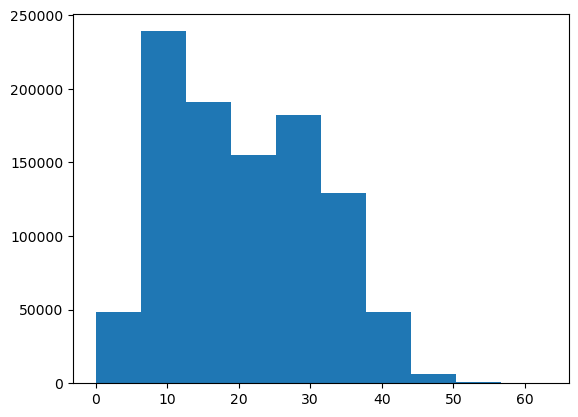

In [62]:
import matplotlib.pyplot as plt

plt.hist(TSPB_edge_similarity_matrix.flatten())

In [63]:
# Optimized similarity calculations using cached sets
def calculate_similarity_cached(
    values, edge_sets, node_sets, similarity_measure, best_idx=None
):
    similarities = []

    for idx in range(len(values)):
        if best_idx is not None and idx == best_idx:
            continue  # Skip the best solution when calculating similarity to the best

        # Use precomputed sets
        if similarity_measure == "common edges":
            similarity = (
                len(edge_sets[best_idx] & edge_sets[idx])
                if best_idx is not None
                else None
            )
        elif similarity_measure == "common nodes":
            similarity = (
                len(node_sets[best_idx] & node_sets[idx])
                if best_idx is not None
                else None
            )

        similarities.append((values[idx], similarity))

    return np.array(similarities)

In [64]:
# Function to plot similarity vs objective values
def plot_similarity(data, title, xlabel="Objective Value", ylabel="Similarity"):
    x, y = data[:, 0], data[:, 1]
    plt.scatter(x, y, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Calculate correlation coefficient
    corr, _ = pearsonr(x, y)

    plt.title(f"{title}\nCorr: {corr:.3f}")
    plt.savefig(f"a8/{title}.png")
    plt.show()

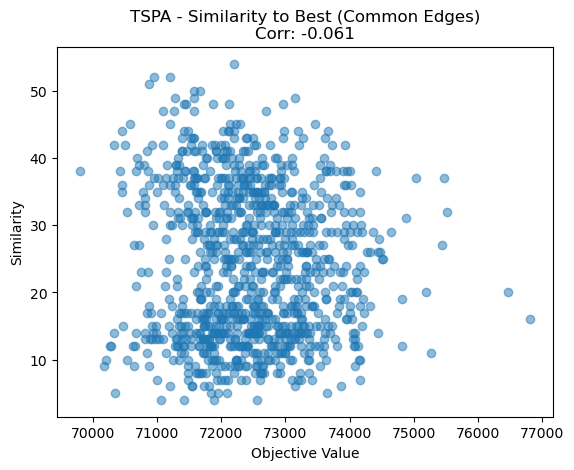

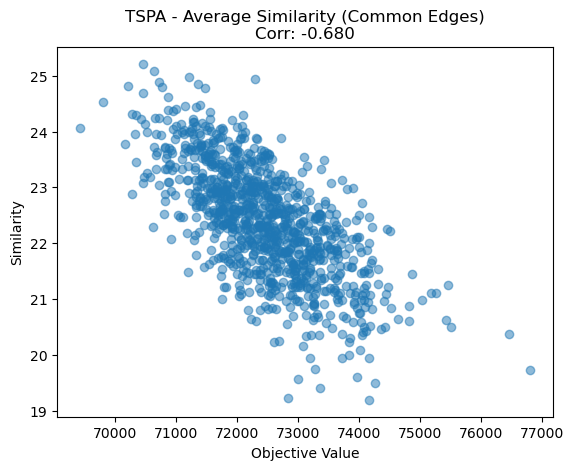

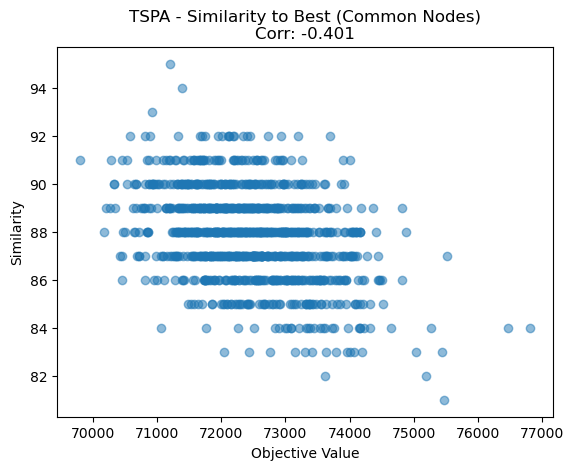

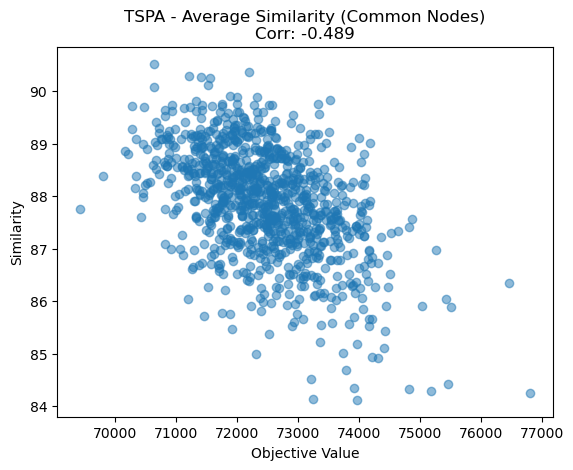

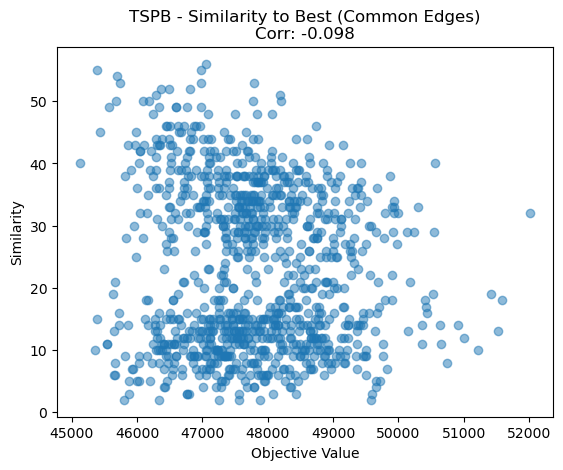

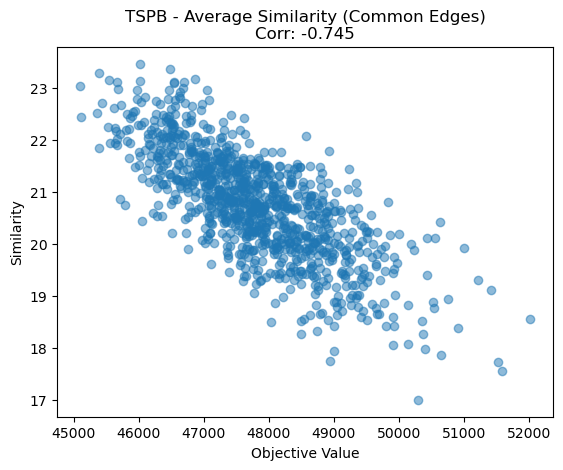

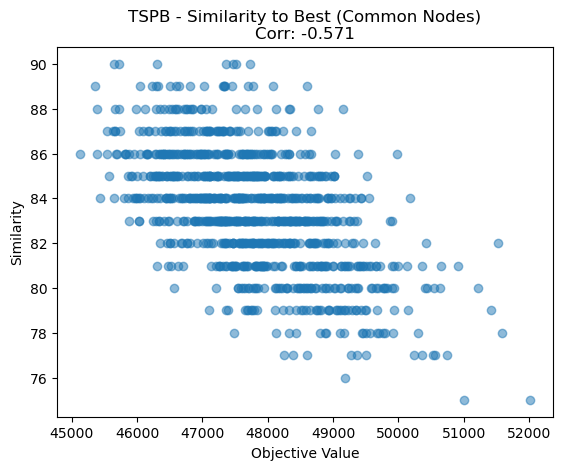

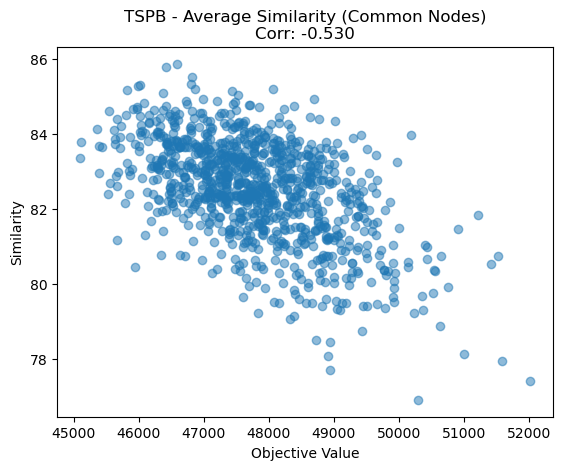

In [65]:
# Analysis
datasets = [
    (
        "TSPA",
        TSPA_values,
        TSPA_edge_sets,
        TSPA_node_sets,
        TSPA_edge_similarity_matrix,
        TSPA_node_similarity_matrix,
    ),
    (
        "TSPB",
        TSPB_values,
        TSPB_edge_sets,
        TSPB_node_sets,
        TSPB_edge_similarity_matrix,
        TSPB_node_similarity_matrix,
    ),
]

for dataset_name, values, edge_sets, node_sets, edge_matrix, node_matrix in datasets:
    for sim_name, similarity_matrix in [
        ("Common Edges", edge_matrix),
        ("Common Nodes", node_matrix),
    ]:
        # Similarity to the best
        best_idx = -1
        for idx, value in enumerate(values):
            if best_idx == -1 or value < values[best_idx]:
                best_idx = idx

        sim_to_best = calculate_similarity_cached(
            values, edge_sets, node_sets, sim_name.lower(), best_idx=best_idx
        )
        plot_similarity(
            sim_to_best, f"{dataset_name} - Similarity to Best ({sim_name})"
        )

        # Average similarity
        avg_sim = calculate_avg_similarity_from_matrix(values, similarity_matrix)
        plot_similarity(avg_sim, f"{dataset_name} - Average Similarity ({sim_name})")